<a href="https://colab.research.google.com/github/gonzalovaldenebro/NaturalLanguageProcessing-Portfolio/blob/main/F3_3_HMMPOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 195: Natural Language Processing
## Hidden Markov Models and Part-of-Speech Tagging

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericmanley/f23-CS195NLP/blob/main/F3_3_HMMPOS.ipynb)


## References

Wisdom ML's *Hidden Markov Model (HMM) in NLP: Complete Implementation in Python*: https://wisdomml.in/hidden-markov-model-hmm-in-nlp-python/

Great Learning's *Part of Speech (POS) tagging with Hidden Markov Model*: https://www.mygreatlearning.com/blog/pos-tagging/

Hidden Markov Model on Wikipedia: https://en.wikipedia.org/wiki/Hidden_Markov_model

Viterbi Algorithm on Wikipedia: https://en.wikipedia.org/wiki/Viterbi_algorithm

In [ ]:
import sys
!{sys.executable} -m pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#you shouldn't need to do this in Colab, but I had to do it on my own machine
#in order to connect to the nltk service
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


## Review: Markov Chain

A **Markov Chain** describes a sequence of possible events and the probabilities of transitioning from one event state to another.

It can be applied to text - what is the probability that one word follows another?

Here is a diagram which corresponds to this text:

`"I code when I am happy. I am happy therefore I code."`

<div>
<img src="https://github.com/ericmanley/f23-CS195NLP/blob/main/images/happy_markov_model.png?raw=1"/>
</div>


## Hidden Markov Model

A **Hidden Markov Model** is a Markov model in which the states of the model are not directly observable - instead, they emit some other observable output that is based on which state it is in.

**Example:** Your weather in your friend's city could be *sunny* or *rainy*, and the transition between them is described by a Markov model. When you talk to your friend on the phone each day, they tell you what they did that day but not what the weather was like.

<div>
<img src="https://github.com/ericmanley/f23-CS195NLP/blob/main/images/weather_hmm.png?raw=1"/ width=400>
</div>

image source: https://en.wikipedia.org/wiki/Hidden_Markov_model#/media/File:HiddenMarkovModel.svg

## What is this useful for?

* lots of non-NLP problems like *protein folding* and *transportation forecasting*
* NLP problems like *speech recognition*, *speech synthesis*, *handwriting recognition*, and *part-of-speech tagging*

**Speech Recognition:** actual words are hidden states (the $x$s), observe audio waves (the $y$s)

**Part-of-Speech Tagging:** part of speech (noun, verb, adjective, etc.) are hidden (the $x$s), observe words (the $y$s)

<div>
<img src="https://github.com/ericmanley/f23-CS195NLP/blob/main/images/HiddenMarkovModel.png?raw=1"/ width=400>
</div>

$a$s: probabilities of transitioning between Markov model states

$b$s: probabilities if emitting observation from a given state

image source: https://en.wikipedia.org/wiki/Hidden_Markov_model#/media/File:HMMGraph.svg

## Example HMM Training


Words:

Mark Page will close the book. Page left a will. Will may mark the page. Will will page Mark.

Words with tags:

Mark *(noun)* Page *(noun)* will *(modal)* close *(verb)* the *(article)* book *(noun)*. Page *(noun)* left *(verb)* a *(article)* will *(noun)*. Will *(noun)* may *(modal)* mark *(verb)* the *(article)* page *(noun)*. Will *(noun)* will *(modal)* page *(verb)* Mark *(noun)*.

### Training the POS Markov Model

We can make the Markov model just from the tags - we can do this with the basic Markov model we used before:

* (start) noun noun modal verb article noun (end)
* (start) noun verb article noun (end)
* (start) noun modal verb article noun (end)
* (start) noun modal verb noun (end)

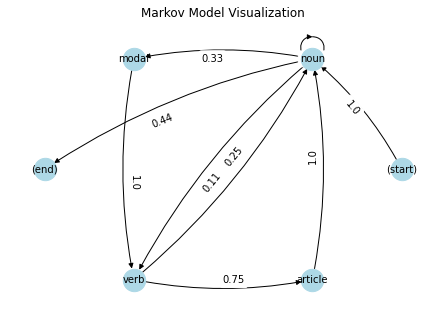

probability of states coming after noun: defaultdict(<class 'float'>, {'noun': 0.1111111111111111, 'modal': 0.3333333333333333, '(end)': 0.4444444444444444, 'verb': 0.1111111111111111})


In [ ]:
from drake_nlp import MarkovModel
import networkx as nx

pos1 = "(start) noun noun modal verb article noun (end)".split()
pos2 = "(start) noun verb article noun (end)".split()
pos3 = "(start) noun modal verb article noun (end)".split()
pos4 = "(start) noun modal verb noun (end)".split()


pos_model = MarkovModel()
pos_model.train(pos1)
pos_model.train(pos2)
pos_model.train(pos3)
pos_model.train(pos4)

pos_model.visualize(probabilities=True,layout=nx.circular_layout) #this doesn't show the noun -> noun probability, but it is 0.11
print("probability of states coming after noun:",pos_model.next_state_probabilities("noun"))

### Calculating the Emission Probabilities

Page *(noun)* will *(modal)* close *(verb)* the *(article)* book *(noun)*. Page *(noun)* left *(verb)* a *(article)* will *(noun)*. Will *(noun)* may *(modal)* mark *(verb)* the *(article)* page *(noun)*. Will *(noun)* can *(modal)* page *(verb)* Mark *(noun)*.

First let's make a table where we count how often we see each word as a given part-of-speech


| Words  | noun | modal | verb | article |
|--------|------|-------|------|---------|
| page   | 3    | 0     | 1    | 0       |
| will   | 3    | 2     | 0    | 0       |
| close  | 0    | 0     | 1    | 0       |
| the    | 0    | 0     | 0    | 2       |
| book   | 1    | 0     | 0    | 0       |
| left   | 0    | 0     | 1    | 0       |
| a      | 0    | 0     | 0    | 1       |
| may    | 0    | 1     | 0    | 0       |
| mark   | 2    | 0     | 1    | 0       |


We can see that there are 9 total nouns, and page is 3 of them, thus the probability of emitting "page" from the *noun* state is $3/9 \approx 0.33$

Let's do this for the whole table:

| Words  | noun | modal | verb | article |
|--------|------|-------|------|---------|
| page   | 0.33    | 0     | 0.25    | 0       |
| will   | 0.33    | 0.67     | 0    | 0       |
| close  | 0    | 0     | 0.25    | 0       |
| the    | 0    | 0     | 0    | 0.67       |
| book   | 0.11    | 0     | 0    | 0       |
| left   | 0    | 0     | 0.25    | 0       |
| a      | 0    | 0     | 0    | 0.33       |
| may    | 0    | 0.33     | 0    | 0       |
| mark   | 0.22    | 0     | 0.25    | 0       |

## Using a model to make predictions

<div>
<img src="https://github.com/ericmanley/f23-CS195NLP/blob/main/images/pos_markov_chain.png?raw=1"/>
</div>

| Words  | noun | modal | verb | article |
|--------|------|-------|------|---------|
| page   | 0.33    | 0     | 0.25    | 0       |
| will   | 0.33    | 0.67     | 0    | 0       |
| close  | 0    | 0     | 0.25    | 0       |
| the    | 0    | 0     | 0    | 0.67       |
| book   | 0.11    | 0     | 0    | 0       |
| left   | 0    | 0     | 0.25    | 0       |
| a      | 0    | 0     | 0    | 0.33       |
| may    | 0    | 0.33     | 0    | 0       |
| mark   | 0.22    | 0     | 0.25    | 0       |

Sentence with unknown parts-of-speech: "Will will page Mark"

What is the probability that this will be tagged as (start) noun modal verb noun (end)?

* probability of transitioning from *(start)* to *noun*: 1
* probability of emitting *will* from *noun*: 0.33
* probability of transitioning from *noun* to *modal*: 0.33
* probability of emitting *will* from *modal*: 0.67
* probability of transitioning from *modal* to *verb*: 1
* probability of emitting *page* from *verb*: 0.25
* probability of transitioning from *verb* to *noun*: 0.25
* probability of emitting *mark* from *noun*: 0.22
* probability of transitioning from *noun* to *(end)*: 0.5

Final probability = $1*0.33*0.33*0.67*1*0.25*0.25*0.22*0.5 \approx 0.0005$

This seems low, but it is the highest probability of any possible tagging!


probability of (start) noun noun verb noun (end): $1*0.33*0.11*0.33*1*0.25*0.25*0.22*0.5 \approx 0.000085$

probability of (start) noun noun noun noun (end): $1*0.33*0.11*0.33*0.11*0.33*0.11*0.22*0.5 \approx 0.000005$

Many probabilites are 0 - for instance, you can't transition from *article* to *verb* or emit "page" from *article*, so the probability of (start) noun verb article verb (end) is 0.


## Calculating Emission Probabilities Automatically

We need a data structure to store the emission probabilties.

Could be a 2D array/matrix

Here's an example of using a dictionary of dictionaries of floats
* default dict so that we can easily deal with words or pos states we haven't yet seen

In [ ]:
from collections import defaultdict

#default dictionary of dictionary of float
#entries  will be 0.0 by default
emission_probabilities = defaultdict(lambda: defaultdict(float))

emission_probabilities["noun"]["page"] = 0.33
emission_probabilities["noun"]["will"] = 0.33
emission_probabilities["noun"]["book"] = 0.11
emission_probabilities["noun"]["mark"] = 0.22

emission_probabilities["modal"]["will"] = 0.67
emission_probabilities["modal"]["may"] = 0.33

emission_probabilities["verb"]["page"] = 0.25
emission_probabilities["verb"]["close"] = 0.25
emission_probabilities["verb"]["left"] = 0.25
emission_probabilities["verb"]["mark"] = 0.25

emission_probabilities["article"]["the"] = 0.67
emission_probabilities["article"]["a"] = 0.33


print("Missing entry:",emission_probabilities["modal"]["page"])

display(emission_probabilities)

Missing entry: 0.0


defaultdict(<function __main__.<lambda>()>,
            {'noun': defaultdict(float,
                         {'page': 0.33,
                          'will': 0.33,
                          'book': 0.11,
                          'mark': 0.22}),
             'modal': defaultdict(float,
                         {'will': 0.67, 'may': 0.33, 'page': 0.0}),
             'verb': defaultdict(float,
                         {'page': 0.25,
                          'close': 0.25,
                          'left': 0.25,
                          'mark': 0.25}),
             'article': defaultdict(float, {'the': 0.67, 'a': 0.33})})

## Group Exercise

Suppose your data is in a data structure that looks like this. Create a function that computes the emission probabilities automatically.





In [ ]:
def calculate_emission_probabilities(list_of_sentences):

    #step 1: initialize emission counts
    emission_counts = defaultdict(lambda: defaultdict(int))

    #step 2: count how many times you see each (word,pos) pair
    #loop through all sentences
        #loop through all (word,pos) pairs in the sentence
            #add 1 to emission_counts[pos][word]

    #step 3: for each pos state calculate how many total occurrences there were
    #e.g., 9 nouns, 4 verbs, etc.

    #step 4: create emission_probabilities by dividing emission_counts
    # by the total occurrences for that pos state

    #step 5: return emission_probabilities
    return None # change this


sentences = [[("mark", "noun"), ("page", "noun"), ("will", "modal"), ("close", "verb"), ("the","article"), ("book", "noun")],
    [("page", "noun"), ("left", "verb"), ("a", "article"), ("will", "noun")],
    [("will", "noun"), ("may", "modal"), ("mark", "verb"), ("the", "article"), ("page", "noun")],
    [("will", "noun"), ("will", "modal"), ("page", "verb"), ("mark", "noun")]]

ep = calculate_emission_probabilities(sentences)

## Viterbi Algorithm

*Dynamic programming algorithm* for computing the highest possible sequence of states through the HMM.

Basic idea: simultaneously calculate probability of all possible paths
* only need to base calculations for next word from the previous one and the current transition and emission probabilities



**First observation:** probability of each POS state is probability of transitioning from *(start)* to that state multiplied by the emission probability of that that word from that state.

This model can only transition from *(start)* to *noun* - probability 1 (0 all others)

0.33 probability to emit "will" from *noun*.

|     | will | will | page | mark |
| --- | ---- | ---- | ---- | ---- |
| noun     |  0.33    |      |      |      |
| modal    |  0    |      |      |      |
| verb     |  0    |      |      |      |
| article  |  0    |      |      |      |


**Second observation:** multiply highest probability observation from observation 1 (0.33) by transition and emission probabilities for the second

*noun* $\rightarrow$ *noun* (0.11), "will" from *noun* (0.33): $0.33 *  (0.11 * 0.33) \approx 0.012$

*noun* $\rightarrow$ *modal* (0.33), "will" from *modal* (0.67): $0.33 * (0.33 * 0.67) \approx 0.073$

*noun* $\rightarrow$ *verb* (0.11), "will" from *verb* (0.0): $0.33 * (0.11 * 0.0) \approx 0.0$

*noun* $\rightarrow$ *verb* (0.0), "will" from *verb* (0.0): $0.33 * (0.0 * 0.0) \approx 0.0$





|     | will | will | page | mark |
| --- | ---- | ---- | ---- | ---- |
| noun     |  0.33    | 0.012     |      |      |
| modal    |  0    |  0.073    |      |      |
| verb     |  0    |   0   |      |      |
| article  |  0    |   0   |      |      |

**Third observation:**

Consider "page" as a noun - which is higher?
* 0.012 * (probability of going *noun* $\rightarrow$ *noun*) * (probability of emitting "page" from noun) $\approx 0.00044$
* 0.073 * (probability of going *modal* $\rightarrow$ *noun*) * (probability of emitting "page" from noun) $= 0$
* technically calculate passing through verb and article too

Consider "page" as a verb - which is higher?
* 0.012 * (probability of going *noun* $\rightarrow$ *verb*) * (probability of emitting "page" from verb) $\approx 0.00033$
* 0.073 * (probability of going *modal* $\rightarrow$ *verb*) * (probability of emitting "page" from verb) $\approx 0.018$
* technically calculate passing through verb and article too

Technically consider the ones where emission probability is 0 too


|     | will | will | page | mark |
| --- | ---- | ---- | ---- | ---- |
| noun     |  0.33    | 0.012     |  0.00044    |      |
| modal    |  0    |  0.073    |   0   |      |
| verb     |  0    |   0   |   0.018   |      |
| article  |  0    |   0   |  0    |      |

## Group Exercise

What's next? Calculate the probabilities to determine the probability of "mark" being a *noun* or *verb*.

Remember:

probability of going *noun* $\rightarrow$ *noun* is 1

probability of going *verb* $\rightarrow$ *noun* is 0.25

probability of going *verb* $\rightarrow$ *verb* is 0

probability of going *noun* $\rightarrow$ *verb* is 0.11

emission probability of "mark" from "noun" is 0.22

emission probability of "mark" from "verb" is 0.25

## Final step

You have to also keep track of which transitions were used in each calculation.

Start at the end and follow the path back to the beginning that led to that highest probability.

## Some Viterbi code

First, repeating the model-building code from above

In [ ]:
from drake_nlp import MarkovModel
import networkx as nx

pos1 = "(start) noun noun modal verb article noun (end)".split()
pos2 = "(start) noun verb article noun (end)".split()
pos3 = "(start) noun modal verb article noun (end)".split()
pos4 = "(start) noun modal verb noun (end)".split()


pos_model = MarkovModel()
pos_model.train(pos1)
pos_model.train(pos2)
pos_model.train(pos3)
pos_model.train(pos4)

from collections import defaultdict

#default dictionary of dictionary of float
#entries  will be 0.0 by default
emission_probabilities = defaultdict(lambda: defaultdict(float))

emission_probabilities["noun"]["page"] = 0.33
emission_probabilities["noun"]["will"] = 0.33
emission_probabilities["noun"]["book"] = 0.11
emission_probabilities["noun"]["mark"] = 0.22

emission_probabilities["modal"]["will"] = 0.67
emission_probabilities["modal"]["may"] = 0.33

emission_probabilities["verb"]["page"] = 0.25
emission_probabilities["verb"]["close"] = 0.25
emission_probabilities["verb"]["left"] = 0.25
emission_probabilities["verb"]["mark"] = 0.25

emission_probabilities["article"]["the"] = 0.67
emission_probabilities["article"]["a"] = 0.33



### Setting up our data structures

In [ ]:
observation = ["will","will","page","mark"] #the sentence we're going to tag
states = pos_model.get_state_list() #we added this to our MarkovModel code from before
print(states)

#state-observation table from above
state_observation_table = defaultdict(lambda: defaultdict(float))
#keep track of the state that led to this place in the state-observation table
prior_state = defaultdict(lambda: defaultdict(str))

['(start)', 'noun', 'modal', 'verb', 'article']


### initialize the first column

just multiply the probability of transition *(start)* $\rightarrow$ each state by emission probability of the observed word from that state

In [ ]:
for state in states:
    state_observation_table[state][0] = pos_model.next_state_probabilities("(start)")[state]*emission_probabilities[state][observation[0]]

display(state_observation_table)

defaultdict(<function __main__.<lambda>()>,
            {'(start)': defaultdict(float, {0: 0.0}),
             'noun': defaultdict(float, {0: 0.33}),
             'modal': defaultdict(float, {0: 0.0}),
             'verb': defaultdict(float, {0: 0.0}),
             'article': defaultdict(float, {0: 0.0})})

### continue for the rest of the observations

for each *to_state* - the state we're considering transitioning into for this word
* find the best *from_state* to transition from - multiply the previous column by transition probability and emission probability
* record the from state in the `prior_state`

In [ ]:
for observation_idx in range(1,len(observation)):
    for to_state in states:
        best_from_state = None
        best_from_state_probability = 0.0
        for from_state in states:
            curr_prob = state_observation_table[from_state][observation_idx-1]*pos_model.next_state_probabilities(from_state)[to_state]*emission_probabilities[to_state][observation[observation_idx]]
            if curr_prob > best_from_state_probability:
                best_from_state_probability = curr_prob
                best_from_state = from_state
        state_observation_table[to_state][observation_idx] = state_observation_table[best_from_state][observation_idx-1]*pos_model.next_state_probabilities(best_from_state)[to_state]*emission_probabilities[to_state][observation[observation_idx]]
        prior_state[to_state][observation_idx] = best_from_state

    display(state_observation_table) #display for each observation

defaultdict(<function __main__.<lambda>()>,
            {'(start)': defaultdict(float, {0: 0.0, 1: 0.0}),
             'noun': defaultdict(float, {0: 0.33, 1: 0.012100000000000001}),
             'modal': defaultdict(float, {0: 0.0, 1: 0.0737}),
             'verb': defaultdict(float, {0: 0.0, 1: 0.0}),
             'article': defaultdict(float, {0: 0.0, 1: 0.0}),
             None: defaultdict(float, {0: 0.0})})

defaultdict(<function __main__.<lambda>()>,
            {'(start)': defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.0}),
             'noun': defaultdict(float,
                         {0: 0.33,
                          1: 0.012100000000000001,
                          2: 0.0004436666666666667}),
             'modal': defaultdict(float, {0: 0.0, 1: 0.0737, 2: 0.0}),
             'verb': defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.018425}),
             'article': defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.0}),
             None: defaultdict(float, {0: 0.0, 1: 0.0})})

defaultdict(<function __main__.<lambda>()>,
            {'(start)': defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}),
             'noun': defaultdict(float,
                         {0: 0.33,
                          1: 0.012100000000000001,
                          2: 0.0004436666666666667,
                          3: 0.001013375}),
             'modal': defaultdict(float, {0: 0.0, 1: 0.0737, 2: 0.0, 3: 0.0}),
             'verb': defaultdict(float,
                         {0: 0.0,
                          1: 0.0,
                          2: 0.018425,
                          3: 1.2324074074074075e-05}),
             'article': defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}),
             None: defaultdict(float, {0: 0.0, 1: 0.0, 2: 0.0})})

### Find the best final state

Note that in these examples, we're ignore the ("end") state - we could include that in the calculation if we wanted to - in this simple example, we always end on a noun, so it would make the choice trivial

In [ ]:
best_final_state = None
best_final_state_prob = 0
for state in states:
    if state_observation_table[state][len(observation)-1] > best_final_state_prob:
        best_final_state_prob = state_observation_table[state][len(observation)-1]
        best_final_state = state

print(best_final_state, best_final_state_prob)

noun 0.001013375


### Make the list of states - backing up from the end

The result is our prediction for each word

In [ ]:
best_states = [best_final_state]

for observation_idx in range(len(observation)-1,0,-1):
    prev_best_state = prior_state[best_states[0]][observation_idx]
    best_states.insert(0,prev_best_state)

print(best_states)


['noun', 'modal', 'verb', 'noun']


## A Corpus with tagged sentences to work from

The Penn Treebank corpus in `nltk` has sentences tagged with parts-of-speech

Parts-of-speech list here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:
import nltk
from pprint import pprint

#nltk.download('treebank') #only need to do it once
sentences = nltk.corpus.treebank.tagged_sents()

#let's look at the first 5
pprint(sentences[0:5])

[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')],
 [('Rudolph', 'NNP'),
  ('Agnew', 'NNP'),
  (',', ','),
  ('55', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  ('and', 'CC'),
  ('former', 'JJ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Consolidated', 'NNP'),
  ('Gold', 'NNP'),
  ('Fields', 'NNP'),
  ('PLC', 'NNP'),
  (',', ','),
  ('was', 'VBD'),
  ('named', 'VBN'),
  ('*-1', '-NONE-'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('of', 'IN'),
  ('this'

## Applied Exploration

Run the model-building code and Viterbi algorithm with some of the Penn Treebank data
* practice by training with a small number of sentences
* test on some sentences (you may need to use one of the same you trained on to make sure you've seen all those words and POS states)
* when you have it working, random sample train and test sets
* calculate how well the model does on the test set (accuracy - how many words did you get right over the total number of words)


## Extended Implementation Idea

Generalize the code
* Make a HiddenMarkovModel class
    * method for training
    * method for predicting on new sentences
    * methods for testing
* Perform a large experiment using your code with Penn Treebank data or other data sets